In [ ]:
!pip install chart_studio

In [ ]:
#Import Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime
%matplotlib inline
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot,init_notebook_mode
import cufflinks
from fbprophet import Prophet
from statsmodels.tsa.statespace.varmax import VARMAX

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
#Importing the dataset 

df = pd.read_csv('/content/GLB.Ts+dSST.csv',skiprows = 1)
df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.17,-0.23,-0.08,-0.15,-0.09,-0.20,-0.17,-0.09,-.14,-.22,-.21,-.16,-.16,***,***,-0.11,-0.15,-.19
1,1881,-0.19,-0.13,0.04,0.06,0.07,-0.18,0.01,-0.02,-.14,-.21,-.17,-.06,-.08,-.08,-.16,0.06,-0.06,-.17
2,1882,0.17,0.15,0.05,-0.16,-0.14,-0.22,-0.16,-0.06,-.14,-.23,-.16,-.36,-.10,-.08,.09,-0.08,-0.15,-.18
3,1883,-0.28,-0.36,-0.12,-0.18,-0.17,-0.07,-0.07,-0.13,-.21,-.11,-.23,-.10,-.17,-.19,-.33,-0.16,-0.09,-.19
4,1884,-0.12,-0.07,-0.36,-0.39,-0.33,-0.34,-0.32,-0.27,-.26,-.25,-.33,-.30,-.28,-.26,-.10,-0.36,-0.31,-.28


In [ ]:
df.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
137,2017,1.02,1.14,1.16,0.94,0.91,0.72,0.82,0.87,.77,.90,.87,.93,.92,.91,1.00,1.01,0.80,.85
138,2018,0.81,0.85,0.88,0.88,0.82,0.77,0.83,0.76,.80,1.01,.82,.91,.85,.85,.86,0.86,0.79,.88
139,2019,0.93,0.95,1.17,1.01,0.84,0.91,0.94,0.94,.92,1.01,1.00,1.09,.98,.96,.93,1.01,0.93,.98
140,2020,1.16,1.24,1.17,1.13,1.02,0.92,0.90,0.87,.99,.88,1.11,.81,1.02,1.04,1.17,1.11,0.90,.99
141,2021,0.81,0.64,0.89,0.76,0.79,0.85,0.92,0.81,***,***,***,***,***,***,.75,0.81,0.86,***


In [ ]:
dateRng =  pd.date_range(start='1/1/1880', end='1/12/2021', freq='M')
type(dateRng[0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
t = pd.DataFrame(dateRng,columns = ['date'])
t['Avg_anomaly_degC'] = None
t.set_index('date',inplace = True)
t.head()


,Avg_anomaly_degC
date,
1880-01-31,None
1880-02-29,None
1880-03-31,None
1880-04-30,None
1880-05-31,None


In [ ]:
df = df.iloc[:,:13]
df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1880,-0.17,-0.23,-0.08,-0.15,-0.09,-0.20,-0.17,-0.09,-.14,-.22,-.21,-.16
1,1881,-0.19,-0.13,0.04,0.06,0.07,-0.18,0.01,-0.02,-.14,-.21,-.17,-.06
2,1882,0.17,0.15,0.05,-0.16,-0.14,-0.22,-0.16,-0.06,-.14,-.23,-.16,-.36
3,1883,-0.28,-0.36,-0.12,-0.18,-0.17,-0.07,-0.07,-0.13,-.21,-.11,-.23,-.10
4,1884,-0.12,-0.07,-0.36,-0.39,-0.33,-0.34,-0.32,-0.27,-.26,-.25,-.33,-.30


In [ ]:
df.describe()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,1950.500000,0.051690,0.058662,0.073521,0.051056,0.041197,0.026197,0.049648,0.048028
std,41.135953,0.412379,0.417810,0.418066,0.385558,0.366528,0.360755,0.340366,0.355111
min,1880.000000,-0.810000,-0.630000,-0.630000,-0.590000,-0.550000,-0.520000,-0.510000,-0.540000
25%,1915.250000,-0.240000,-0.240000,-0.230000,-0.250000,-0.240000,-0.240000,-0.190000,-0.220000
50%,1950.500000,-0.020000,-0.040000,0.005000,-0.040000,-0.045000,-0.055000,-0.035000,-0.050000
75%,1985.750000,0.300000,0.370000,0.300000,0.270000,0.270000,0.230000,0.220000,0.227500
max,2021.000000,1.170000,1.370000,1.360000,1.130000,1.020000,0.920000,0.940000,1.020000


In [ ]:
def populate_df_with_anomalies(row):
    year = row['Year']
    monthly_anomalies = row.iloc[1:]
    months = monthly_anomalies.index
    
    for month in months:
        last_day = calendar.monthrange(year,datetime.strptime(month,'%b').month)[1]
        date_index = datetime.strptime(f'{year} {month} {last_day}','%Y %b %d')
        t.loc[date_index] = monthly_anomalies[month]

In [ ]:
_ = df.apply(lambda row:populate_df_with_anomalies(row),axis = 1)

In [ ]:
t.head()

,Avg_anomaly_degC
date,
1880-01-31,-0.17
1880-02-29,-0.23
1880-03-31,-0.08
1880-04-30,-0.15
1880-05-31,-0.09


In [ ]:
def clean_df_values(val):
    try:
        return float(val)
    except:
        return np.NaN

In [ ]:
t['Avg_anomaly_degC'] = t['Avg_anomaly_degC'].apply(lambda val: clean_df_values(val))
t.fillna(method = 'ffill',inplace = True)
t.head()

,Avg_anomaly_degC
date,
1880-01-31,-0.17
1880-02-29,-0.23
1880-03-31,-0.08
1880-04-30,-0.15
1880-05-31,-0.09


In [ ]:
t.isnull().sum()

Avg_anomaly_degC    0
dtype: int64

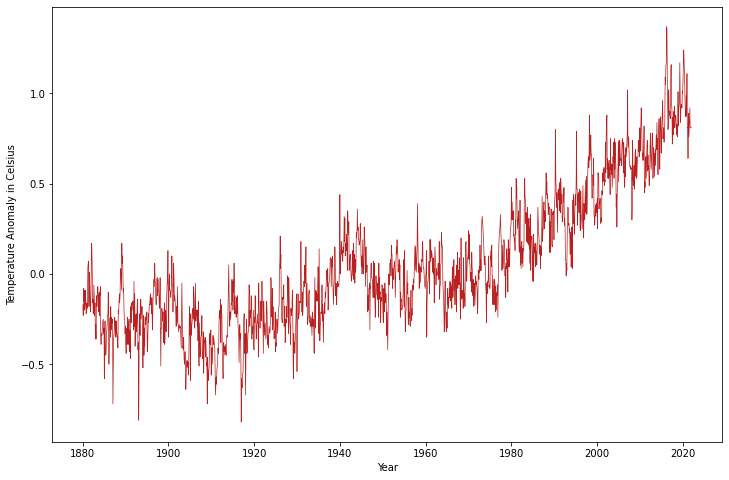

In [ ]:
plt.figure(figsize = (12,8))
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly in Celsius')
plt.plot(t,color = '#BB2020',linewidth = 0.7)

In [ ]:
t.resample('A').mean().head()

,Avg_anomaly_degC
date,
1880-12-31,-0.159167
1881-12-31,-0.076667
1882-12-31,-0.105000
1883-12-31,-0.169167
1884-12-31,-0.278333


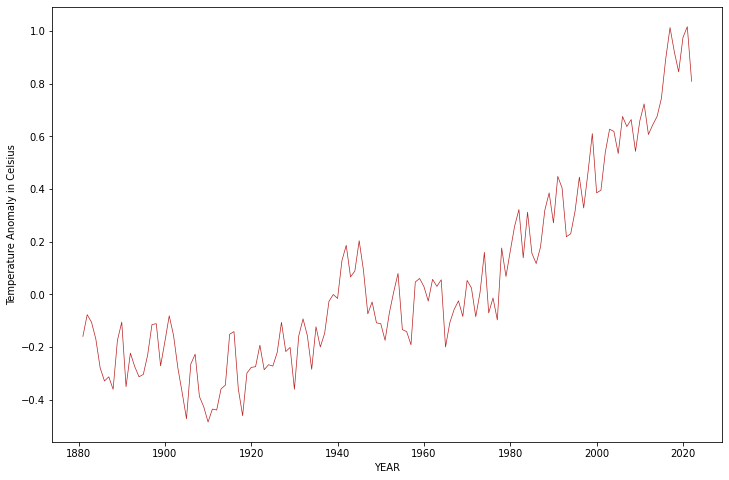

In [ ]:
#visualize our resampled dataframe
plt.figure(figsize = (12,8))
plt.xlabel('YEAR')
plt.ylabel('Temperature Anomaly in Celsius')
plt.plot(t.resample('A').mean(),color = '#BB2020',linewidth = 0.7)

In [ ]:
cufflinks.go_offline(connected = True)
init_notebook_mode(connected = True)
t.resample('A').mean().iplot(kind='line', xTitle='Years)', color='#BB2020',
                  yTitle='Temperature Anomaly in Celsius', title='Global Temperature Anomalies',width = 2)

In [ ]:
#creating dataframe for a model
df_prophet = pd.DataFrame()
df_prophet['ds'] = t.index
df_prophet['y'] = t['Avg_anomaly_degC'].values
df_prophet.head()

,ds,y
0,1880-01-31,-0.17
1,1880-02-29,-0.23
2,1880-03-31,-0.08
3,1880-04-30,-0.15
4,1880-05-31,-0.09


In [ ]:
model = Prophet()
model.fit(df_prophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


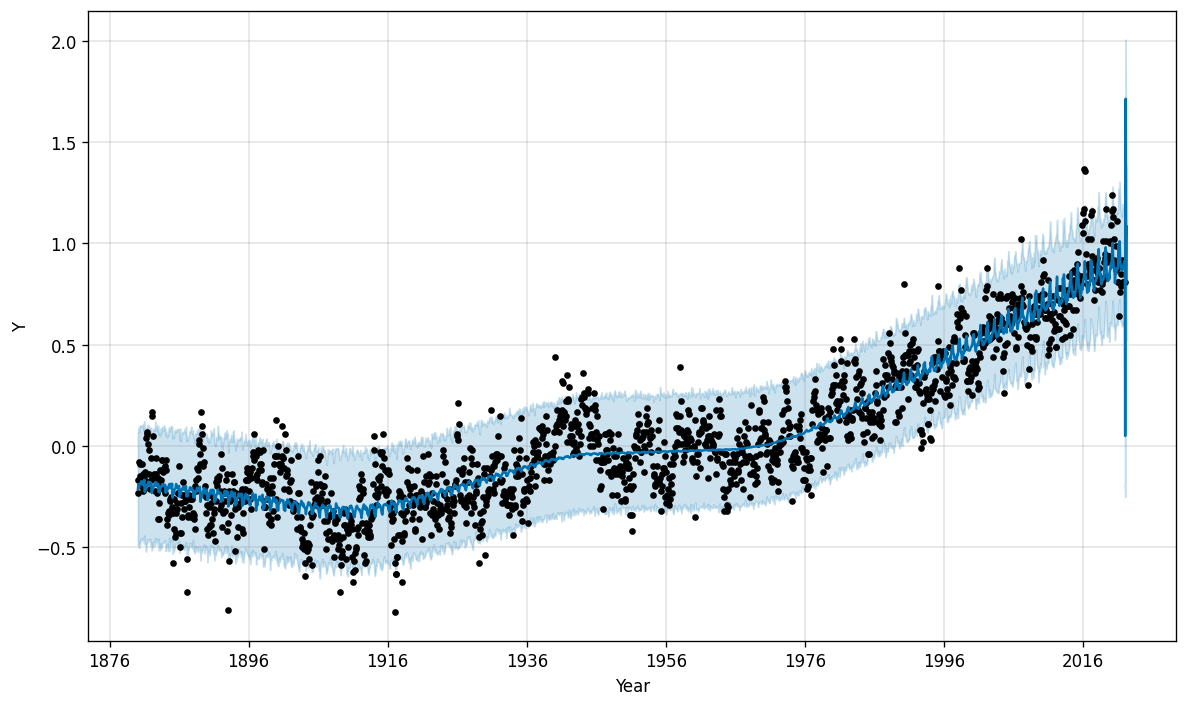

In [ ]:

# instantiate the model and set parameters
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)

# fit the model to data
model.fit(df_prophet)

future_pd = model.make_future_dataframe(
    periods=90,
    freq='d',
    include_history=True
)

# predict over the dataset
forecast_pd = model.predict(future_pd)

predict_fig = model.plot(forecast_pd, xlabel='Year', ylabel='Y')


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


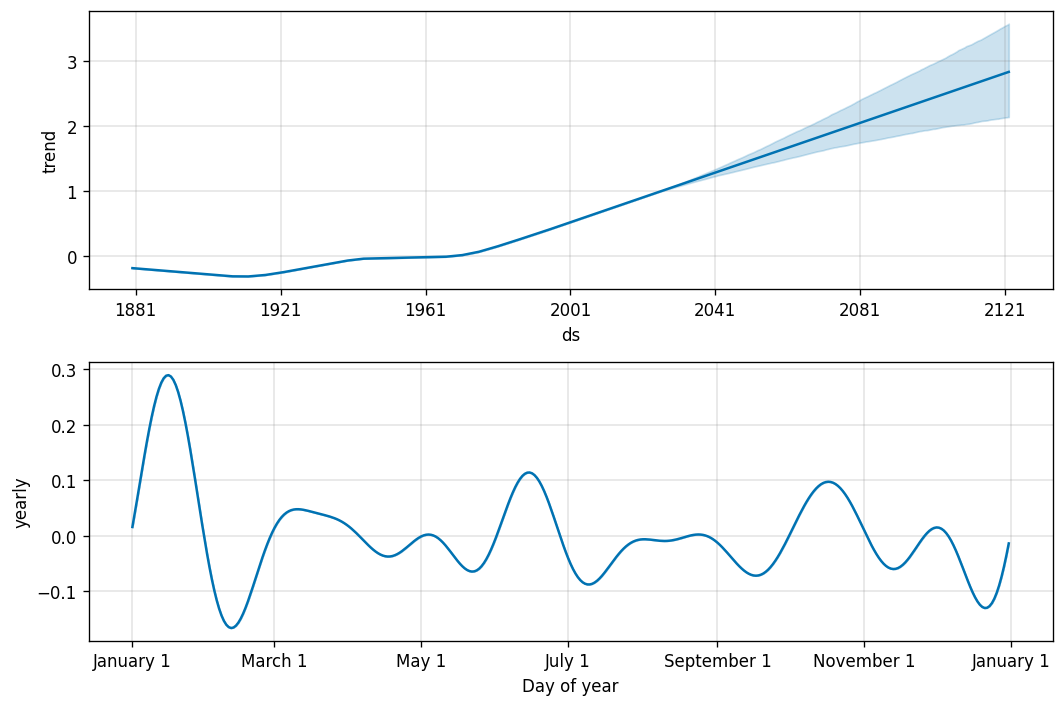

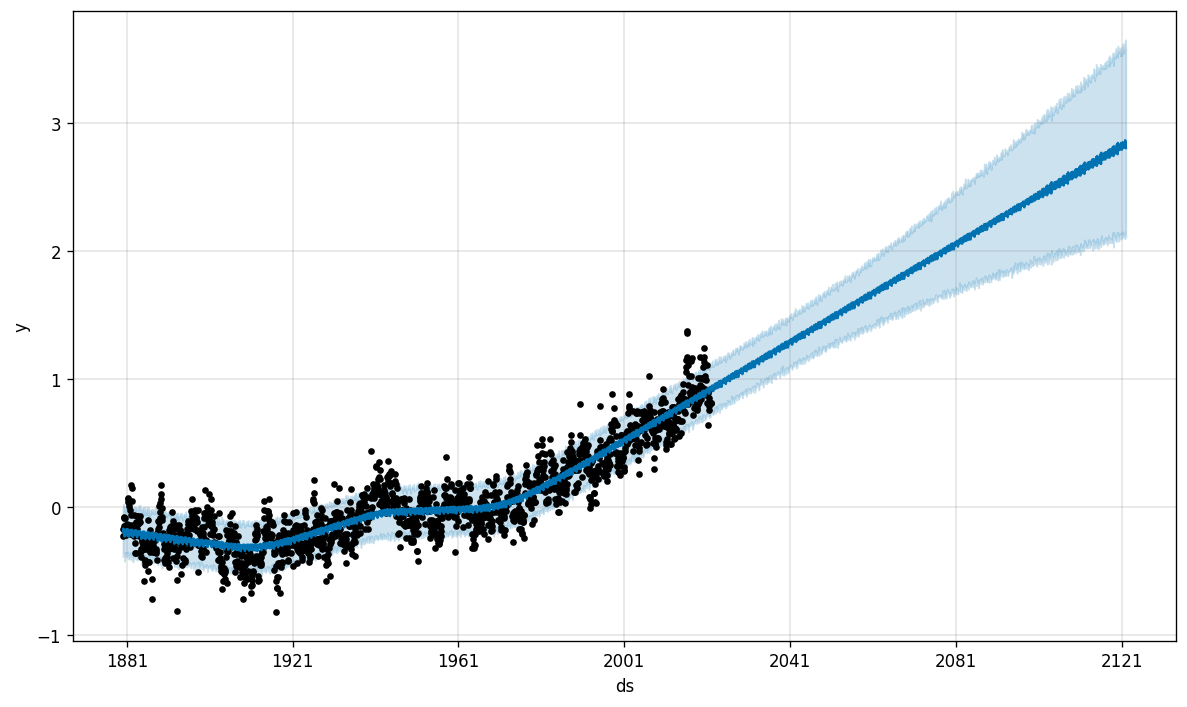

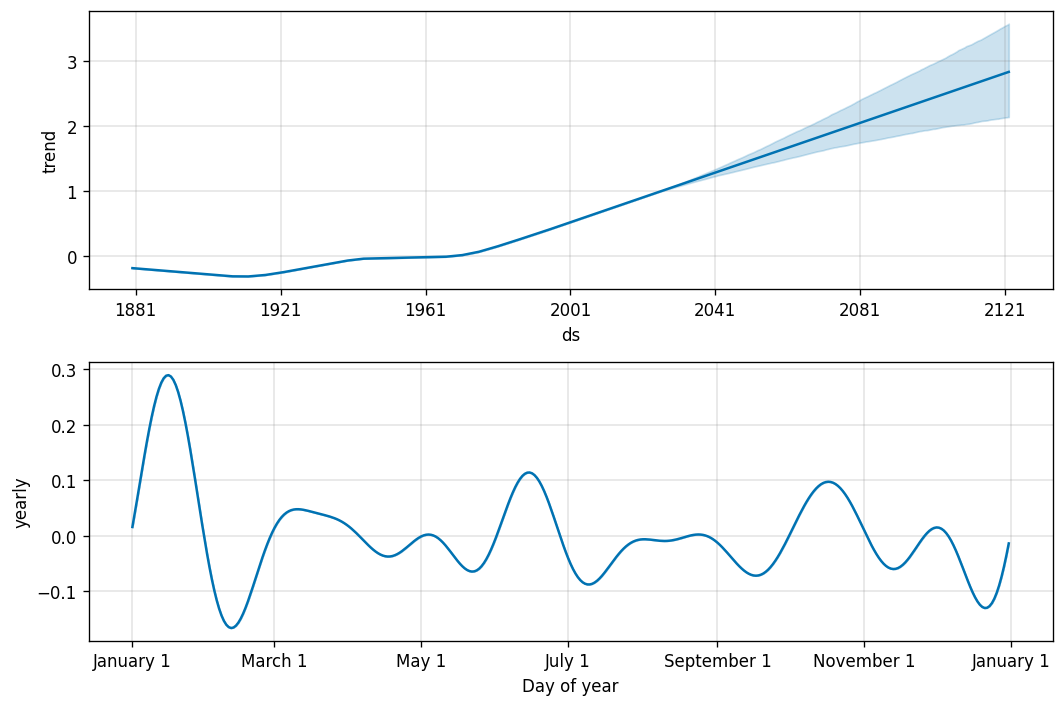

In [ ]:
model2 = Prophet()
model2.fit(df_prophet)

#generating future dataframe containing prediction
future_df = model.make_future_dataframe(freq ='m',periods = 100*12)
forecast = model.predict(future_df)
model2.plot(forecast)

#ploting forecast components
model2.plot_components(forecast)